In [1]:
import sys
sys.executable
#sys.path

'/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/bin/python'

In [4]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from PIL import Image, ImageDraw
from os.path import join
import descartes

# import earthpy.spatial as es
# import earthpy.plot as ep
# import earthpy.clip as ec
# import earthpy.mask as em

import fiona 
import pyproj
import time

In [5]:
from platform import python_version
print(python_version())

3.7.5


In [6]:
# local paths
path_data = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset'
area = 'Mosul_2015'
path_file = 's1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif'
path_file_border_mask = 's1tiling_S1A_IW_GRDH_1SDV_20151222T030932_20151222T030957_009149_00D2A0_F04A/38SLF/s1a_38SLF_vv_DES_20151222t030932_BorderMask.tif'


shape_file = '38SLF_Mosul.shp'
file_label = shape_file[-0:-4] + path_file[-19:-4]

path_raster = join(path_data, area, path_file)
path_border_mask = join(path_data, area, path_file_border_mask)
#path_shape_file = join(path_data, area, shape_file)
path_shape_file = '/Users/jurriaan/ML/UNOSAT_Challenge/UNOSAT-Challenge/38SLF_Mosul.shp'

output = join('/Volumes/other/datasets_and_ML/UNOSAT_Challenge/output_test', 'mosul_test.tif')

In [7]:
file_label

'38SLF_Mosul20150108t030926'

### shape file

https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/

In [8]:
polygons = gpd.read_file(path_shape_file)

DriverError: Unable to open /Users/jurriaan/ML/UNOSAT_Challenge/UNOSAT-Challenge/38SLF_Mosul.shx or /Users/jurriaan/ML/UNOSAT_Challenge/UNOSAT-Challenge/38SLF_Mosul.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
polygons.head(), polygons.total_bounds, polygons.shape

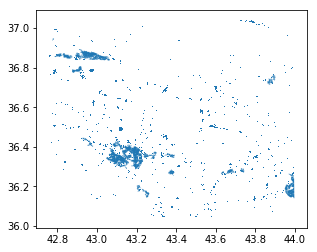

In [11]:
polygons.plot()

In [12]:
# get coordinatesin python list
g = [i for i in polygons.geometry]
all_coords = [mapping(g_i)["coordinates"] for g_i in g]

In [13]:
all_coords[:2]

[(((43.779087810840636, 37.03939453669721),
   (43.779896284993086, 37.03939453669721),
   (43.779896284993086, 37.03903521485169),
   (43.779087810840636, 37.03903521485169),
   (43.779087810840636, 37.03939453669721)),),
 (((43.75411494257608, 37.03903521485169),
   (43.75465392534438, 37.03903521485169),
   (43.75465392534438, 37.0389453843903),
   (43.75411494257608, 37.0389453843903),
   (43.75411494257608, 37.03903521485169)),)]

In [14]:
len(all_coords)

5645

In [2]:
#polygons.__dict__

### raster file

In [17]:
# open raster data
raster_obj= rio.open(path_raster)
# optional - view spatial extent
raster_obj.bounds

RasterioIOError: /Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif: Operation not permitted

In [ ]:
raster_obj.meta

In [ ]:
# read in all of the data without specifying a band
with rio.open(path_raster) as src:
    # convert / read the data into a numpy array:
    mosul_dem_im = src.read(masked= False)
    sjer_ext = rio.plot.plotting_extent(src)

# view array shape -- notice that you have 3 dimensions below
print(mosul_dem_im.shape)

In [ ]:
mosul_first = mosul_dem_im[0]
mosul_first

In [ ]:
mosul_slice = mosul_first[100:300,100:300]

In [ ]:
#try Matplotlib
n1 = 7000
n2 = 8800
fig, ax = plt.subplots()
ax.imshow(mosul_first[n1:n2,n1:n2],  interpolation='nearest')

plt.show()

In [ ]:
#try PIL 
# img = Image.fromarray(1 - mosul_first[n1:n2,n1:n2])
# img.show()

# doesnt show more

## process raster: clipping, transform, normalization

In [10]:
np_arr_read = raster_obj.read()

In [ ]:
np_arr = np_arr_read[0]

In [ ]:
sum(sum(np_arr))

In [ ]:
np_arr.max(), np_arr.min(), np.median(np_arr), np.std(np_arr)

In [ ]:
# need to clip and stretch contrast of  figure
clip_min=0
clip_max=2

arr_clip = np.clip(np_arr, clip_min, clip_max)

In [ ]:
rio.plot.show_hist(arr_clip, bins=100)

In [ ]:
def exponent(x, a, b):
    return a*x**b

In [ ]:
def log(x, a, b):
    return np.log(a*x + b)

In [ ]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [ ]:
a = 1
b = 0.5

a_l = 1
b_l = 0.1

array_exp = exponent(arr_clip, a, b)
array_log = log(arr_clip, a_l, b_l)
np_arr_norm = normalize(arr_clip)
np_arr_exp_norm = normalize(array_exp)
np_arr_log_norm = normalize(array_log)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.hist(np_arr_norm.flatten(), bins=100);
ax2.hist(np_arr_exp_norm.flatten(), bins=100);
ax3.hist(np_arr_log_norm.flatten(), bins=100);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np_arr_norm, cmap='pink')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np_arr_exp_norm, cmap='pink')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np_arr_log_norm, cmap='pink')
plt.show()

## arrays2raster 

### further explorations with raster

In [ ]:
np.save('np_array', np_arr_norm)

In [ ]:
# save as raster
#rasterize_shp(template_raster, shp, dtype, options,output,nodata_val=0)


In [ ]:
# from https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(32638)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main_arr2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster


In [ ]:
# from https://geohackweek.github.io/raster/04-workingwithrasters/


with rio.open(path_raster) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:32638')

    lon,lat = (35, 36)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Mosul-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 0, 0
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    print('lon,lat of row, col: ({}, {}) = {}, {}'.format(row, col, lon, lat) )

        

In [ ]:
rasterOrigin = (30.00050, 410.00350)
pixelWidth = np_arr_norm.shape[0]
pixelHeight = np_arr_norm.shape[1]
newRasterfn = 'raster_test.tif'
main_arr2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, np_arr_norm)

## visualize with earthpy

see: https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_rgb.html

###  4 images:

In [ ]:
im1 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vh_DES_20150108t030926.tif')
im2 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150426T030931_20150426T030956_005649_0073E6_2DFA/38SLF/s1a_38SLF_vh_20150426.tif')
im3 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150812T030933_20150812T030958_007224_009E1D_B70E/38SLF/s1a_38SLF_vh_DES_20150812t030933.tif')
im4 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20151222T030932_20151222T030957_009149_00D2A0_F04A/38SLF/s1a_38SLF_vh_DES_20151222t030932.tif')


In [ ]:
# Get list of bands and sort by ascending band number
bands = [im1, im2, im3, im4]

# Create image stack and apply nodata value for Landsat
arr_st, meta = es.stack(bands, nodata=-9999)

In [ ]:
meta

In [ ]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot bands with stretched applied
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1, 0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 RGB Image with Stretch Applied",
)
plt.show()

In [ ]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot NIR, red, and green bands, respectively, with stretch
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1, 0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Stretch Applied",
)
plt.show()

### together with shape 

In [ ]:
n_img = 3 # which raster image

In [ ]:
# Reproject boundary to match CRS of the Landsat images
with rio.open(bands[n_img]) as raster_crs:
    raster_profile = raster_crs.profile
    bound_utm13N = polygons.to_crs(raster_profile["crs"])

In [ ]:
rio.open(bands[n_img]).crs

In [ ]:
raster_profile

In [ ]:
print(bound_utm13N.iloc[0].geometry)

In [ ]:
# Create figure with one plot
extent = plotting_extent(arr_st, raster_profile["transform"])

fig, ax = plt.subplots(figsize=(20,20))

# Plot boundary with high zorder for contrast
bound_utm13N.boundary.plot(ax=ax, color="red", zorder=10, linewidth=10)

#fig, ax2 = plt.subplots(figsize=(20,20))
# Plot NIR, red, and green bands, respectively, with stretch
ep.plot_rgb(
    arr_st,
    rgb=(0,0,0,0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Stretch Applied",
)

plt.show()

#### try again

see: https://gis.stackexchange.com/questions/294072/how-can-i-superimpose-a-geopandas-dataframe-on-a-raster-plot

In [ ]:
path_img_raster_new = '/Users/jurriaan/ML/UNOSAT_Challenge/raster_test.tif'
raster_new = rio.open(path_img_raster_new)

In [ ]:
# Plot boundary with high zorder for contrast
fig, ax = plt.subplots(figsize=(15, 15))
bound.plot(ax=ax, color="red", zorder=10, linewidth=1)
rio.plot.show(raster_new, ax=ax)


## use pyproj: coords2index

In [ ]:
with rio.open(path_raster) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    
    raster_profile = src.profile
    raster_profile["crs"]

In [ ]:
print(raster_obj.crs, polygons.crs)

In [ ]:
#def coords2index(img_raster, shape_file):
# from https://geohackweek.github.io/raster/04-workingwithrasters/
lon,lat = (43.779087810840636, 37.03939453669721)
    
with rio.open(path_raster) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio    
    lonlat = pyproj.Proj(jer_plot_locations.crs)

    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Mosul-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    print('lon,lat of row, col: ({}, {}) = {}, {}'.format(row, col, lon, lat) )

In [ ]:
utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio    
lonlat = pyproj.Proj(init=polygons.crs)

In [ ]:
utm

In [ ]:
lonlat

In [ ]:
def coords2index(raster_obj, polygons, lon, lat):
    utm = pyproj.Proj(raster_obj.crs) # Pass CRS of image from rasterio    
    lonlat = pyproj.Proj(polygons.crs)
    east,north = pyproj.transform(lonlat, utm, lon, lat)
    row, col = src.index(east, north) # spatial --> image coordinates
    return row, col

In [ ]:
# get coordinatesin python list
g = [i for i in polygons.geometry]
all_coords = [mapping(g_i)["coordinates"] for g_i in g]



In [ ]:
all_coords[0][0][0]

In [ ]:
list_polypoints_index = []

for i, coords in enumerate(all_coords):
    lon, lat = coords[0][0]
    list_polypoints_index.append([coords2index(src, polygons, lon, lat)])
    if i % 100 == 0:
        print(i)

In [ ]:
list_polypoints_index[:10]

In [ ]:
out_of_range_x = [c for c in list_polypoints_index if c[0][0] > 10980]
out_of_range_y = [c for c in list_polypoints_index if c[0][1] > 10979]

In [ ]:
out_of_range_x

In [ ]:
out_of_range_y

In [ ]:
print(np_arr_norm.mean(), np.median(np_arr_norm), np_arr_norm.std())

In [ ]:
len(list_polypoints_index)

In [ ]:
# show np_arr_norm and coords of polygons

arr_poly = np.zeros(np_arr_norm.shape)
arr_poly_shapex, arr_poly_shapey = arr_poly.shape
for coord in list_polypoints_index:
    i,j = coord[0]
    i_inv = arr_poly_shapex - i
    j_inv = arr_poly_shapey - j
    
    if 0 <= i_inv <= arr_poly_shapex and 0 <= j_inv <= arr_poly_shapey:
        arr_poly[i_inv, j_inv] = 1
    

In [ ]:
arr_poly.sum()

In [ ]:
arr_poly.shape, np_arr_norm.shape

In [ ]:
np_arr_norm_flp = np.fliplr(np.flipud(np_arr_norm))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
x = [c[0][0] for c in list_polypoints_index]
y = [c[0][1] for c in list_polypoints_index]
ax.imshow(np_arr_norm_flp)
ax.scatter(x,y, s=5, c='white')
#fig.savefig('mosul_raster_points_1')
plt.close()

## Masking a raster using  shapefile => use this for the input data and labels

In [ ]:
#https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

In [11]:
shapes = polygons.geometry

In [12]:
with fiona.open(path_shape_file, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [ ]:
t0 = time.time() # takes about 8 mins
polygons_resh = polygons.to_crs(raster_obj.crs)
print('takes:', time.time() - t0)

In [ ]:
geom = polygons_resh.iloc[0]['geometry']

In [ ]:
polygons_resh

In [ ]:
print(geom)

In [ ]:
geoms = polygons_resh['geometry']
print(geoms)

In [ ]:
# https://gis.stackexchange.com/questions/273390/extract-polygon-pixels-using-lazy-reading-in-rasterio
polygon_mask = rio.features.geometry_mask(geometries=geoms,
                                       out_shape=(raster_obj.height, raster_obj.width),
                                       transform=raster_obj.transform,
                                       all_touched=False,
                                       invert=True)
print(polygon_mask.shape)

In [ ]:
polygon_mask.shape, np_arr_log_norm.shape, np.sum(polygon_mask)

In [ ]:
polygon_mask_int = np.multiply(polygon_mask, 1)

In [ ]:
sum(sum(polygon_mask_int))

In [ ]:
np_arr_norm_mask_int = np.multiply(np_arr_log_norm, polygon_mask_int)

In [ ]:
np_arr_norm_mask_int.shape

In [ ]:
print(np.sum(np.sum(np_arr_norm_mask_int)))
print(np.sum(np.sum(np_arr_log_norm)))

In [ ]:
np.where(polygon_mask_int == 1)

In [ ]:
polygon_mask_int[10, 9142]

In [ ]:
fig, ax = plt.subplots(figsize=(150, 150))
#ax.imshow(polygon_mask, cmap='pink')
ax.contour(polygon_mask, 1, colors='red', linewidths=0.5)
ax.imshow(np_arr_log_norm)
fig.savefig('raster_and_shape_large_{}.png'.format(file_label))

In [ ]:
np_arr_norm_mask_int

In [ ]:
fig, ax = plt.subplots(figsize=(150, 150))
ax.imshow(np_arr_norm_mask_int)
fig.savefig('raster_and_shape_mask_large_{}.png'.format(file_label))

In [ ]:
# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})

# with rasterio.open("masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

In [ ]:
# out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
# out_meta = src.meta